# CAD Challenge 1: Binary classification

## Set things up

### Imports

In [2]:
from skimage.color import  rgb2hsv,  rgb2lab, rgb2yuv
import matplotlib.pyplot as plt
from skimage import io
import numpy as np
import os.path
import os




### Set dataset location

In [3]:
parent_path = os.path.dirname(os.getcwd())

with open(parent_path + '\\dataset_path.txt', 'r') as file:
    dataset_path = file.read().strip()  # Use strip() to remove leading/trailing whitespace

### Set up matplotlib

In [4]:
plt.rcParams['figure.figsize'] = [10, 5]
%matplotlib inline
#%matplotlib widget

Text(0.5, 1.0, 'Other image')

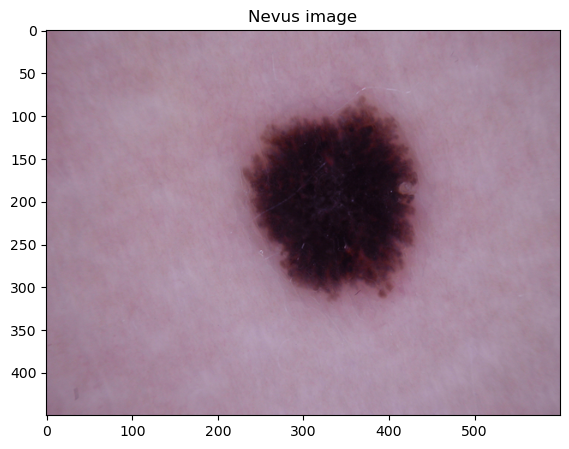

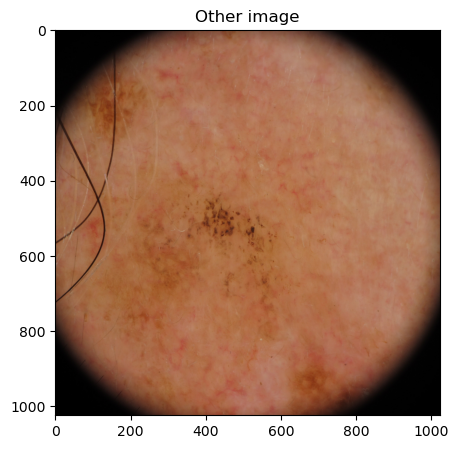

In [5]:
nevus_path = os.path.join(dataset_path, 'train\\nevus')
others_path = os.path.join(dataset_path, 'train\\others')

# get the filenames of all the nevus images in the training dataset
nevus_filenames = os.listdir(nevus_path)

# get the filenames of all the other images in the training dataset 
others_filenames = os.listdir(others_path)

# load the first nevus image
nevus_image = io.imread(os.path.join(nevus_path, nevus_filenames[0]))

# load the first other image
others_image = io.imread(os.path.join(others_path, others_filenames[4]))

plt.figure()
plt.imshow(nevus_image)
plt.title('Nevus image')

plt.figure()
plt.imshow(others_image)
plt.title('Other image')

# Image Descriptors

## Color Features

In [6]:
## TODO: Open the image in 6 diferent color spaces with skimage

def set_colorspace(img, colorspace='rgb'):

    if colorspace == 'rgb':

        return img
    elif colorspace == 'hsv':

        img = rgb2hsv(img)
        img[:, :, 0] /= 360.0

        return img
    elif colorspace == 'lab':

        img = rgb2lab(img)
        img[:, :, 0] /= 100.0
    
        return img
    elif colorspace == 'yuv':

        img = rgb2yuv(img)
        img[:, :, 0] /= 1.0 

        return img
    
    else:
        return img


def colorHistogram(img, color_space='rgb', bins=[256,256,256]):

    colors = ['tab:orange', 'tab:purple', 'tab:cyan']


    fig, ax = plt.subplots(2,3, constrained_layout=True)
    
    histograms = []

    for ci,c in enumerate(color_space):

        b = bins[ci]
        histogram = np.histogram(img[:,:,ci].flatten(), bins=b)

        ax[0,ci].imshow(img[:,:,ci], cmap='gray')

        ax[1,ci].bar(histogram[1][:-1], histogram[0], width=1,color=colors[ci])
        #add subplot title
        ax[1,ci].set_title(c.upper() + ' channel histogram')

        histograms.append(histogram)


    return np.array(histograms)



C:\Users\USER\AppData\Local\Temp\ipykernel_20596\275499880.py:54: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(histograms)


[array([    1,     0,    11,     0,    19,    35,     0,    66,    80,
          189,     0,   297,   496,     0,   747,   944,  1083,     0,
         1099,  1084,     0,  1107,  1098,     0,  1039,  1036,  1028,
            0,   855,   878,     0,   770,   718,   656,     0,   577,
          570,     0,   496,   435,     0,   420,   357,   331,     0,
          258,   299,     0,   269,   271,   251,     0,   243,   211,
            0,   250,   239,   227,     0,   204,   219,     0,   198,
          218,     0,   214,   227,   190,     0,   207,   230,     0,
          198,   197,   199,     0,   181,   196,     0,   178,   202,
            0,   193,   158,   173,     0,   172,   141,     0,   134,
          137,   137,     0,   155,   170,     0,   151,   162,     0,
          166,   172,   162,     0,   173,   157,     0,   167,   178,
          145,     0,   122,   137,     0,   139,   133,   141,     0,
          128,   140,     0,   170,   131,     0,   126,   130,   152,
      

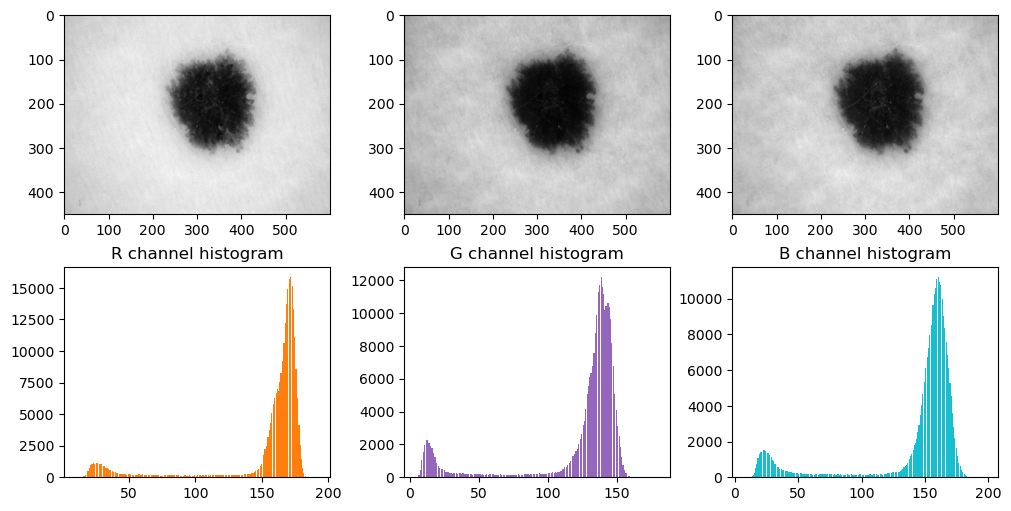

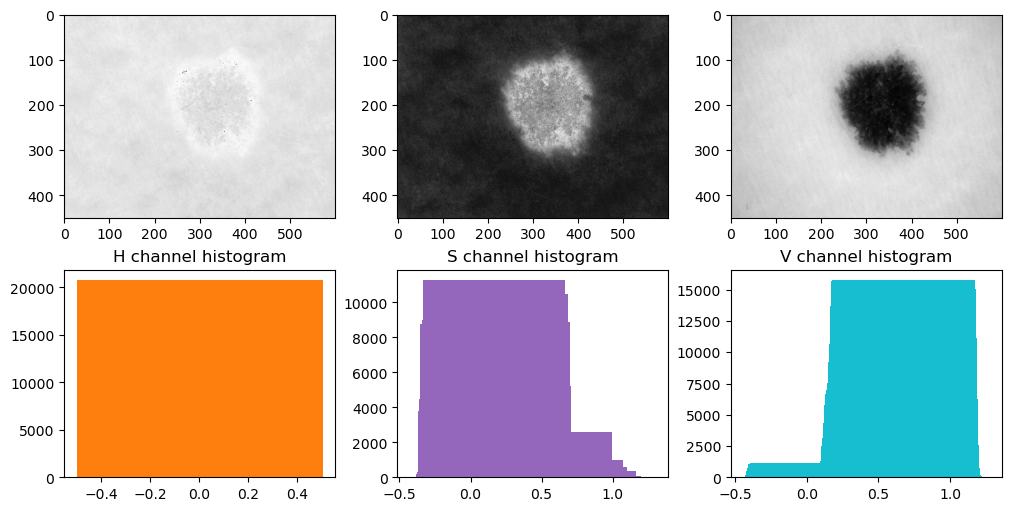

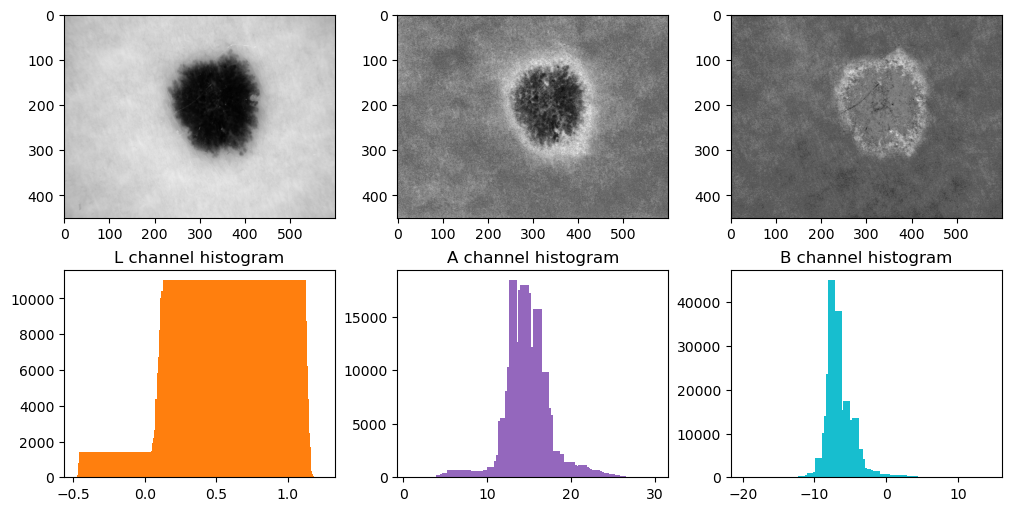

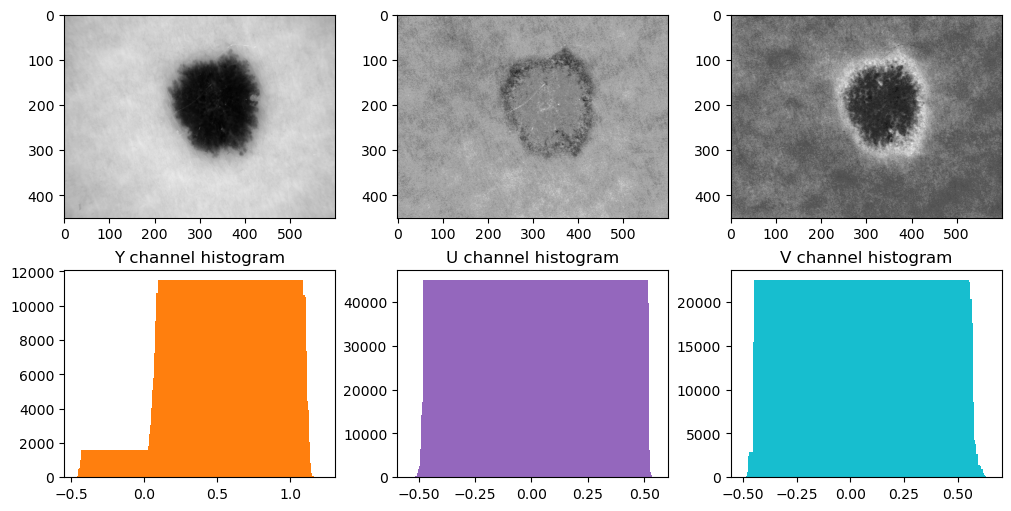

In [7]:
# rgb color space represents an image as a 3D array of red, green, and blue channels
# each channel is a 2D array of pixel values ranging from 0 to 255

# hsv color space represents an image as a 3D array of hue, saturation, and value channels
# hue is the color, saturation is the amount of color, and value is the brightness of the color
# each channel is a 2D array of pixel values ranging from 0 to 1

# lab color space represents an image as a 3D array of lightness, a, and b channels
# lightness is the brightness of the color, a is the green-red channel, and b is the blue-yellow channel
# each channel is a 2D array of pixel values ranging from 0 to 1

# yuv color space represents an image as a 3D array of luminance, u, and v channels
# luminance is the brightness of the color, u is the blue-luminance channel, and v is the red-luminance channel
# each channel is a 2D array of pixel values ranging from 0 to 1

color_spaces = ['rgb', 'hsv', 'lab', 'yuv']

# Bin sizes for each color space
# Bins are used to discretize the values of each channel
bins = {
    'rgb': [256, 256, 256],
    'hsv': [360, 256, 256],
    'lab': [256, 128, 128],
    'yuv': [256, 128, 128]
}

for cs in color_spaces:
    img = set_colorspace(nevus_image, cs)
    h = colorHistogram(img, cs, bins[cs])
    print(h[0])


AttributeError: 'numpy.ndarray' object has no attribute 'type'

## Texture Features